In [84]:
from random import sample
import pandas as pd
import scipy.sparse as sp
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from sklearn.datasets import make_classification, make_blobs, make_circles, make_moons, load_digits
from sklearn.utils import shuffle as sklearn_shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pickle
%matplotlib inline

## SVM

SVM - support vector machine, метод опорных векторов.

Приницип работы SVM классификатора состоит в построении гиперплоскости, разделяющей объекты в некотором пространстве.

Для начала посмотрим на работу классификатора на некоторых искусственных примерах. Ниже сгененировано несколько искусственных разделимых выборок: линейно разделимая, нелинейно разделимая и неразделимая.

In [82]:
X, y = {}, {}
X['blobs'], y['blobs'] = make_blobs(n_samples=400, n_features=2, centers=2, random_state=10, cluster_std=2.2)
X['circles'], y['circles'] = make_circles(n_samples=400, random_state=1, factor=0.2, noise=0.1)
X['moons'], y['moons'] = make_moons(n_samples=400, noise=0.07, random_state=1)
X['mix'], y['mix'] = make_classification(
    n_samples=400, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, random_state=4
)

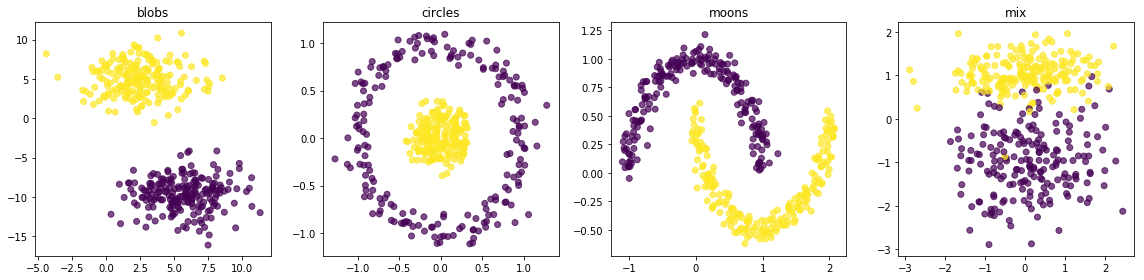

In [153]:
f, axarr = plt.subplots(1, len(X), figsize=(16, 4))
for case, ax in zip(X.keys(), axarr):
    y[case] = np.round(2 * (y[case] - 0.5))
    ax.scatter(X[case][:, 0], X[case][:, 1], c=y[case], alpha=0.7)
    ax.set_title(case);
f.tight_layout()

Протестируем **линейный** SVM  на сгенерированных выборках. На плоскости показана разделяющая прямая и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Опорные вектора выделены точками, обведенными черным контуром. 
Cтроки рисунка соответствуют разным значениям $C$, столбцы - разным выборкам. Перебор $C$ сделан по логарифмической сетке: от 0.01 до 100.

Ниже для каждой из выборок представлен график зависимости числа опорных векторов от параметра $C$. 

Код написан на основе кода со страницы http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html

In [81]:
def plot_model_predict(kernel_value, degree_value):
    param_grid = [0.01, 0.1, 1, 10, 100]
    fig, axarr = plt.subplots(len(X.keys()), len(param_grid), figsize=(20, 16))
    fig.suptitle(kernel_value)
    fig_c_sv, axarr_c_sv = plt.subplots(1, len(X.keys()), figsize=(16, 4))
    num_subplot_c_sv = 0
    for data_set, num_row in zip(X.keys(), np.arange(0, len(X.keys()))):
        num_support_vectors = {}
        for penalty, ax in zip(param_grid, axarr[num_row]):

            # fit the model, don't regularize for illustration purposes
            clf = svm.SVC(kernel=kernel_value, degree = degree_value, C=penalty)
            clf.fit(X[data_set], y[data_set])

            ax.scatter(X[data_set][:, 0], X[data_set][:, 1], c=y[data_set], s=30, cmap=plt.cm.Paired)

            # plot the decision function
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()

            # create grid to evaluate model
            xx = np.linspace(xlim[0], xlim[1], 30)
            yy = np.linspace(ylim[0], ylim[1], 30)
            YY, XX = np.meshgrid(yy, xx)
            xy = np.vstack([XX.ravel(), YY.ravel()]).T
            Z = clf.decision_function(xy).reshape(XX.shape)
            # plot support vectors
            ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=40,
                            facecolors='none', zorder=10, edgecolors='k', linewidth=0.7)

            # plot decision boundary and margins
            ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                       linestyles=['--', '-', '--'])

            ax.set_title(data_set + ', C = ' + str(penalty))

            predicted = clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
            ax.pcolormesh(XX, YY, predicted, alpha=0.05)

            num_support_vectors[penalty] = len(clf.support_vectors_[:, 0])

        ax_c_sv = axarr_c_sv[num_subplot_c_sv] 
        xticks = list(map(lambda x: math.log10(x), num_support_vectors.keys()))
        ax_c_sv.plot(xticks, num_support_vectors.values())
        ax_c_sv.set_title(data_set)
        ax_c_sv.set_ylabel('Number support vectors')
        ax_c_sv.set_xlabel('lg(C)')
        num_subplot_c_sv = num_subplot_c_sv + 1

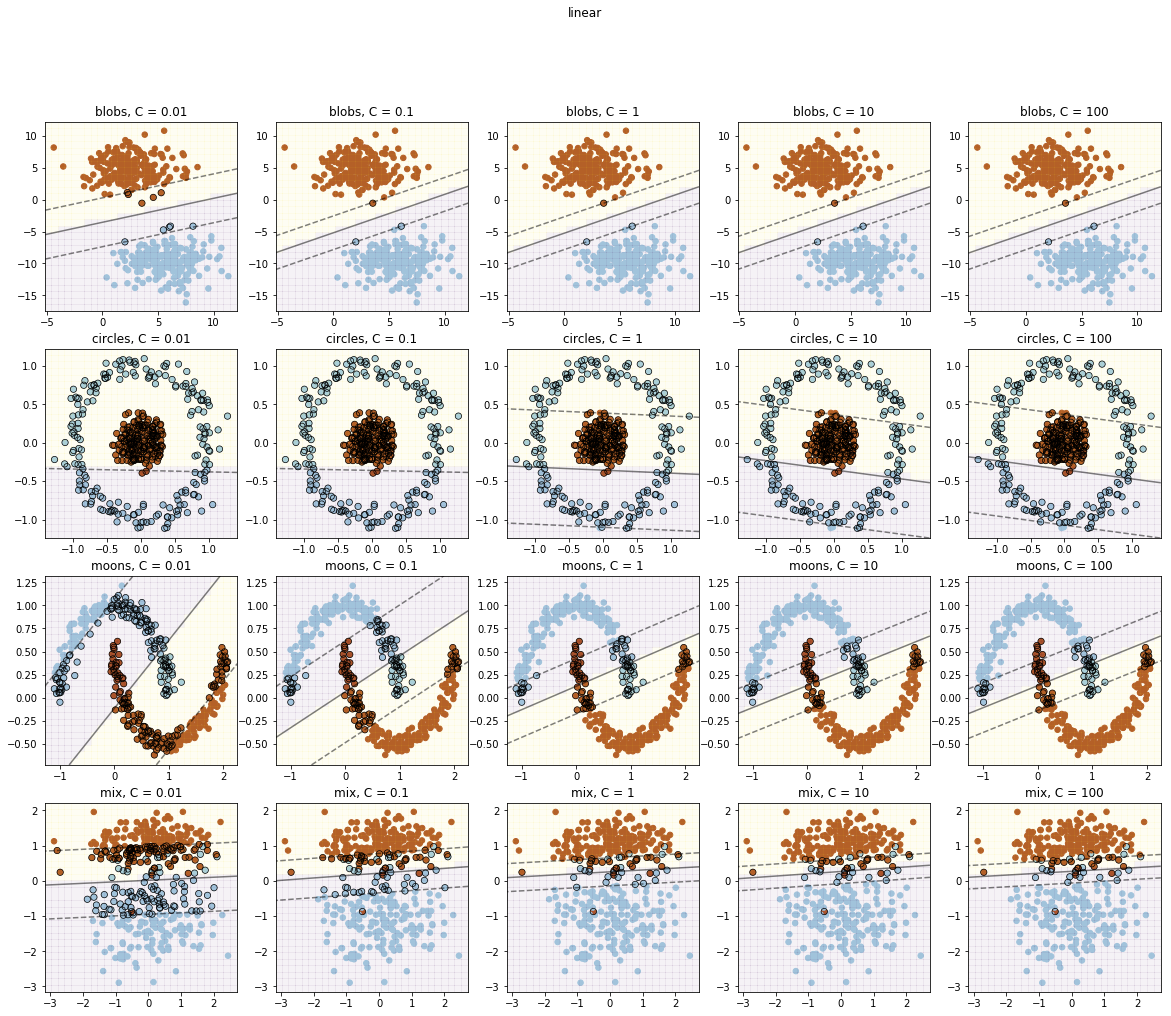

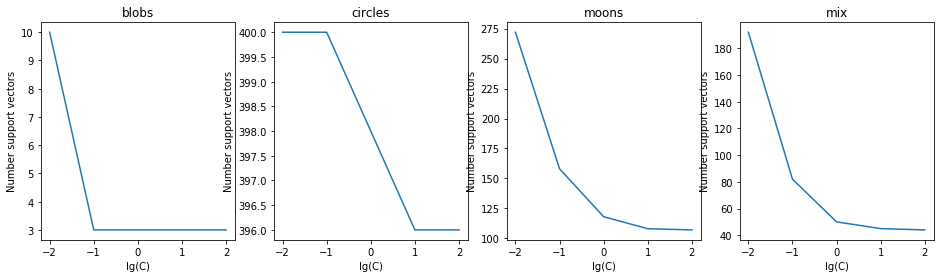

In [201]:
plot_model_predict('linear', 3)

В зависимости от значений $C$ меняется ширина коридора. При большом значении $C$ получается более узкий коридор и меньшее число опорных векторов. **линейный** SVM хорошо справляется с линейно разделимыми пересекающимися и непересекающимися выборками и очень плохо справляется с нелинейно разделимыми выборками.

Аналогично протестируем полиномиальные (со степенями 2 и 3) SVM и SVM с гауссовским ядром на сгенерированных выборках. 

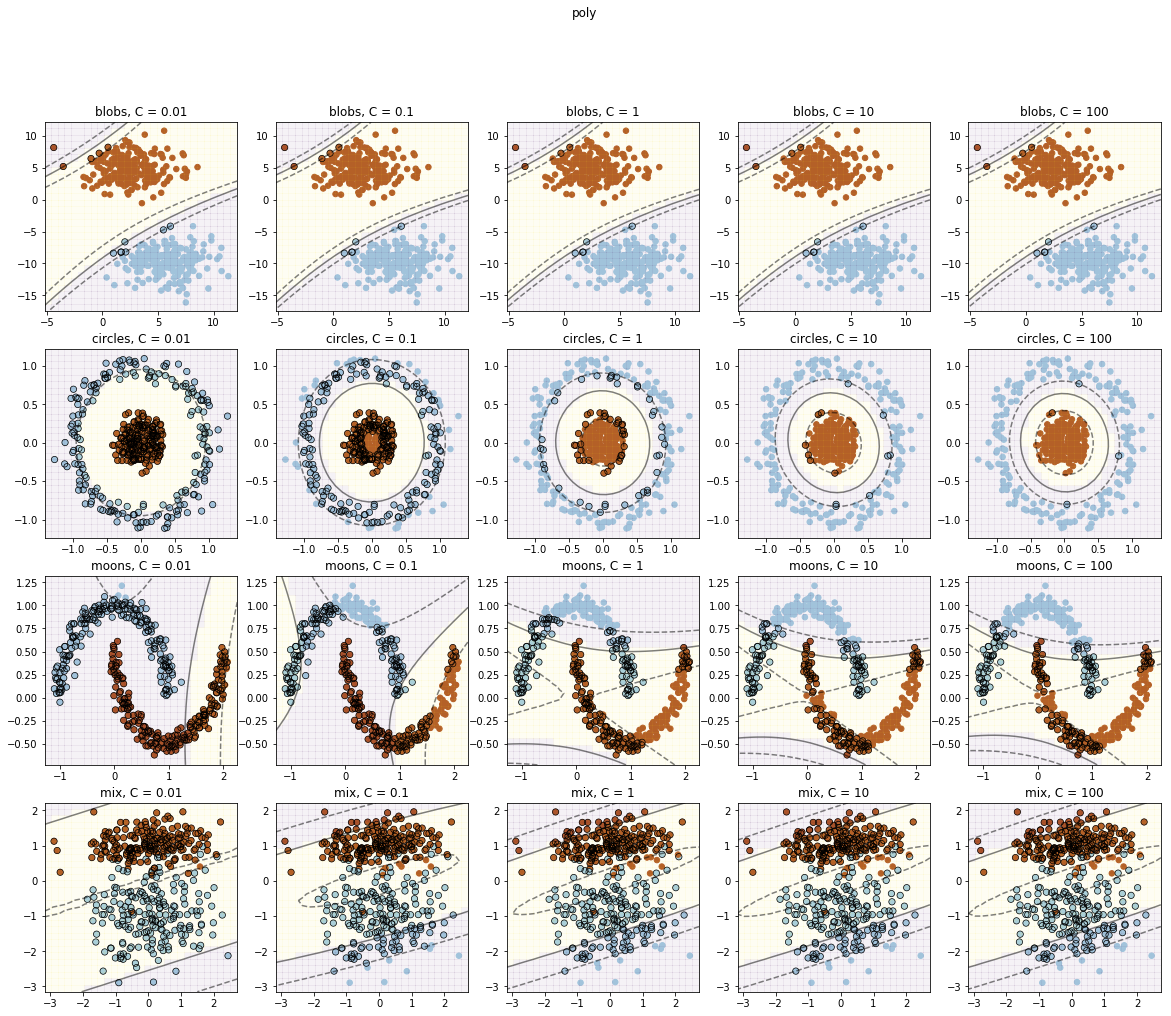

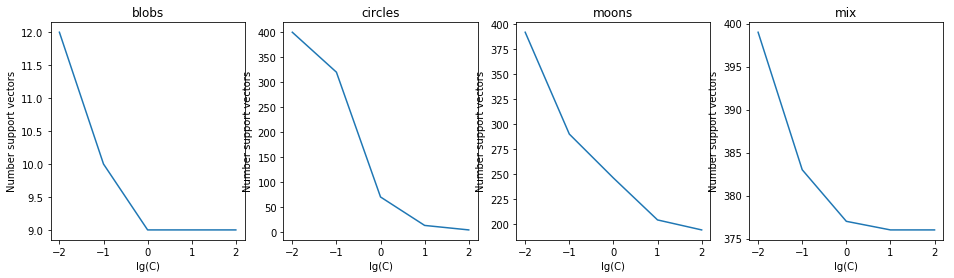

In [193]:
plot_model_predict('poly', 2)

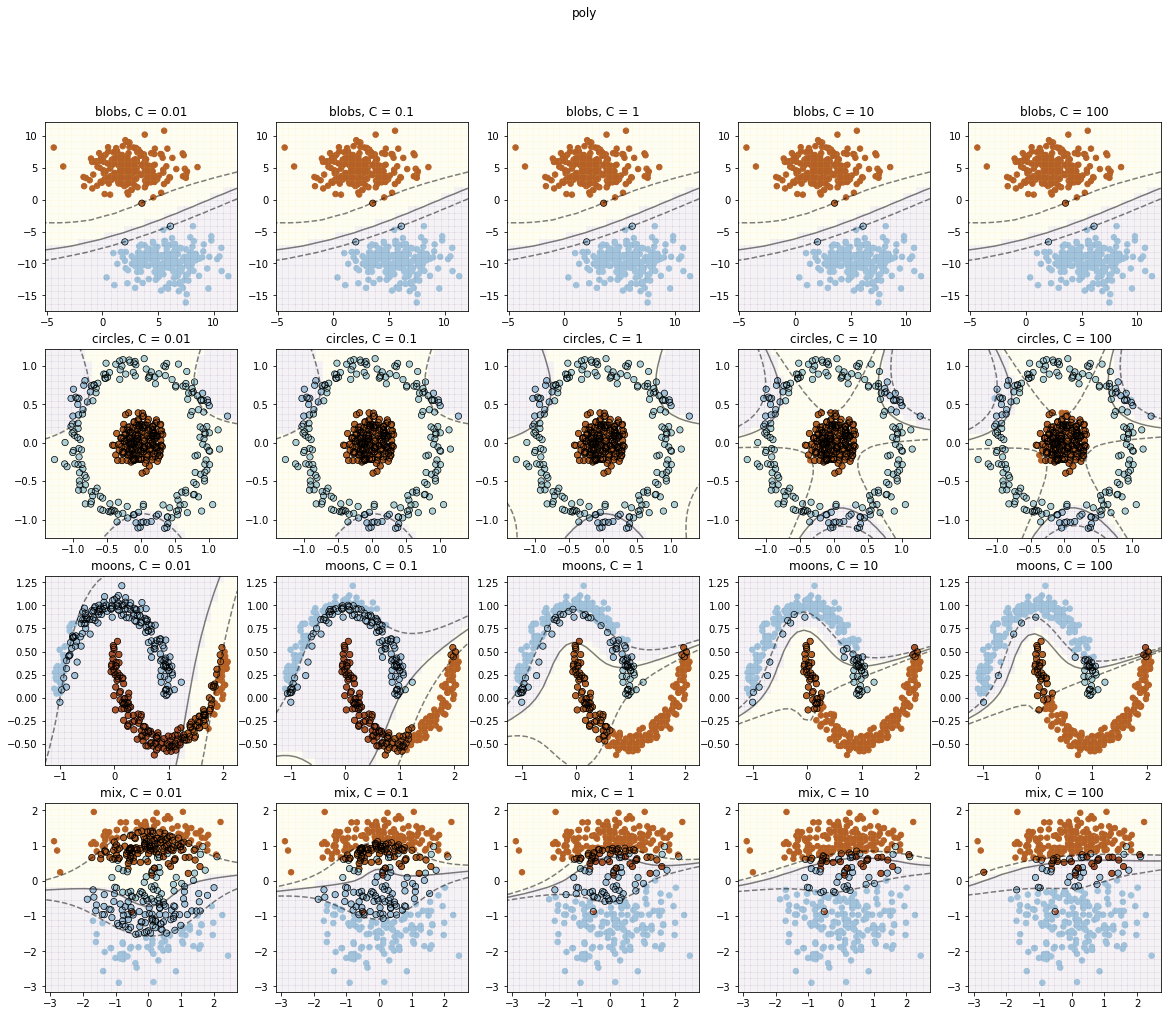

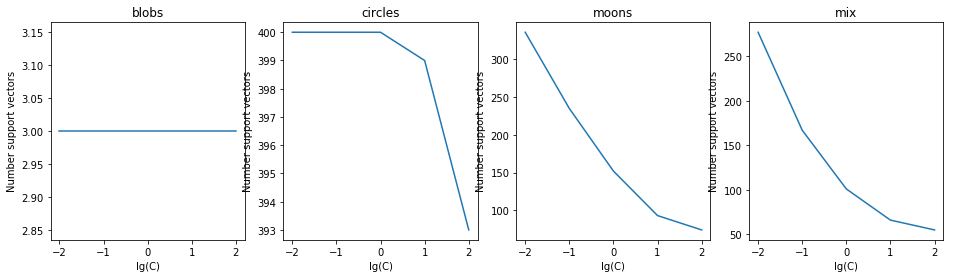

In [195]:
plot_model_predict('poly', 3)

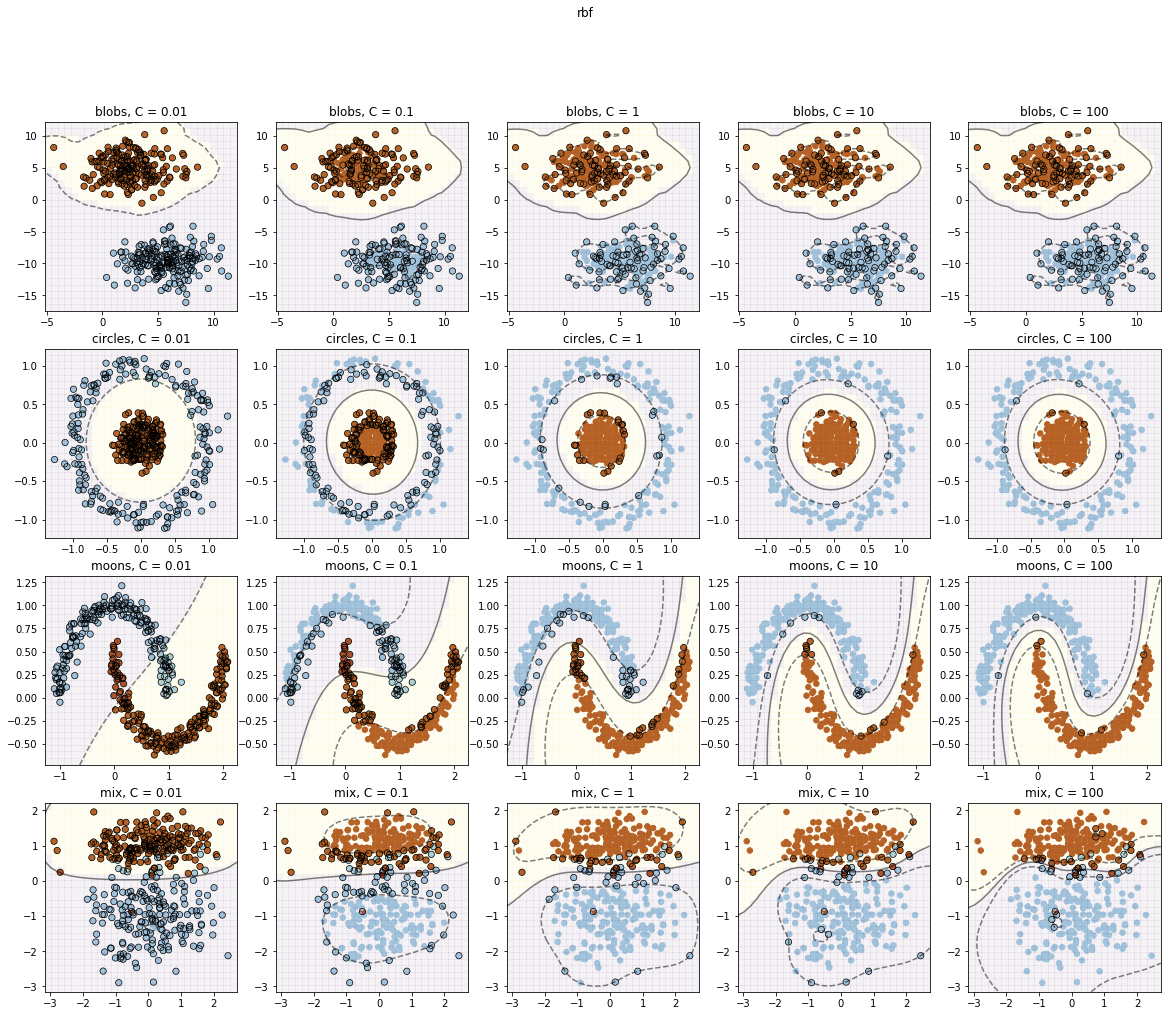

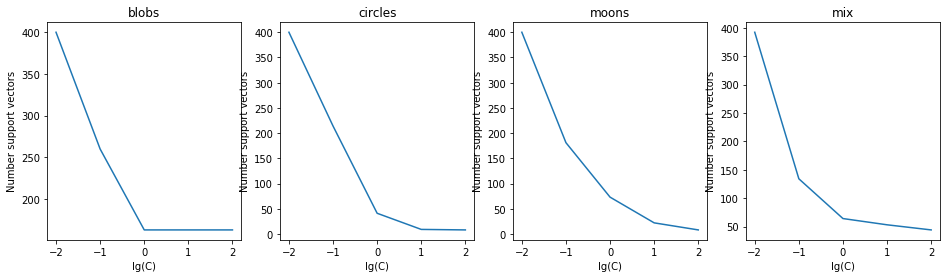

In [194]:
plot_model_predict('rbf', 3)

На нелинейно разделимых выборках (circles и moons) лучше всего работает алгоритм SVM с гауссовским ядром при большом значении параметра С. Однако на линейноразделимых и неразделимых выборках (blobs и mix) немного лучше работает линейный SVM. Полиномиальные SVM практически на всех выборках, кроме blobs, работают хуже, чем SVM с гауссовским ядром, но на нелинейно разделимых выборках работает лучше, чем линейный SVM. 

Будем считать наиболее удачной конфигурацию SVM с гауссовским ядром со значением $C$ = 100 и протестируем поведение SVM на тех же выборках в зависимости от параметра gamma. Перебор $gamma$ сделан по логарифмической сетке: от 0.01 до 100.

In [205]:
def plot_model_predict_gamma(kernel_value):
    param_grid = [0.01, 0.1, 1, 10, 100]
    fig, axarr = plt.subplots(len(X.keys()), len(param_grid), figsize=(20, 16))
    fig.suptitle(kernel_value)
    num_subplot_c_sv = 0
    for data_set, num_row in zip(X.keys(), np.arange(0, len(X.keys()))):
        num_support_vectors = {}
        for gamma_value, ax in zip(param_grid, axarr[num_row]):

            # fit the model, don't regularize for illustration purposes
            clf = svm.SVC(kernel=kernel_value, C=100, gamma = gamma_value)
            clf.fit(X[data_set], y[data_set])

            ax.scatter(X[data_set][:, 0], X[data_set][:, 1], c=y[data_set], s=30, cmap=plt.cm.Paired)

            # plot the decision function
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()

            # create grid to evaluate model
            xx = np.linspace(xlim[0], xlim[1], 30)
            yy = np.linspace(ylim[0], ylim[1], 30)
            YY, XX = np.meshgrid(yy, xx)
            xy = np.vstack([XX.ravel(), YY.ravel()]).T
            Z = clf.decision_function(xy).reshape(XX.shape)
            # plot support vectors
            ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=40,
                            facecolors='none', zorder=10, edgecolors='k', linewidth=0.7)

            # plot decision boundary and margins
            ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                       linestyles=['--', '-', '--'])

            ax.set_title(data_set + ', gamma = ' + str(gamma_value))

            predicted = clf.predict(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
            ax.pcolormesh(XX, YY, predicted, alpha=0.05)

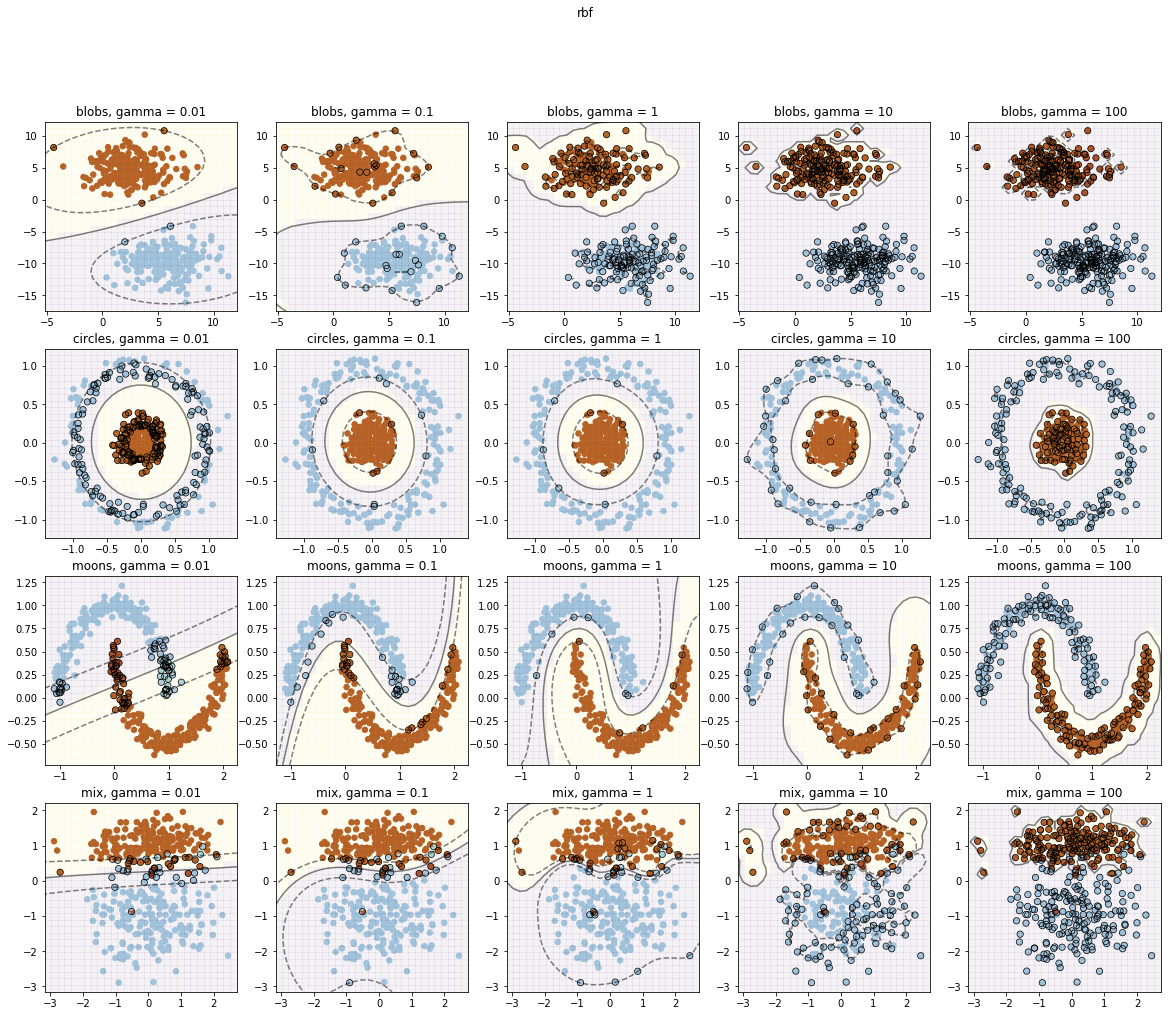

In [206]:
plot_model_predict_gamma('rbf')

При увеличении значения параметра gamma происходит подстраиваниие алгоритма под исходную выборку. Чем больше gamma, тем больше алгоритм переобучается. При маленьком значении gamma, алгоритм работает как линейный. Значение gamma = 1 кажется наиболее оптимальным, если учитывать все варианты выборок. 

Cравним этот классификатор с теми, что мы использовали в предыдущей домашней работе. 

Сравним классификаторы, выбрав их параметры по сетке (возьмем значения из прошлой домашней работы):

 - KNN — *n_neighbors* и *metric*
 - DecisonTree — *max_depth* и *max_features*,
 - RandomForest — *max_depth* и *max_features*,
 - SVC - *C* и *gamma* (ядро - по умолчанию).
 
*В качестве метрики качества используйте ROC-AUC.*

Какой из алгоритмов имеет наилучшее качество? Как различаются их время работы и обучения? Имеет ли какие-нибудь преимущества SVC? Постройте сравнительную табличку для данных классификаторов.

In [58]:
filename = "data.adult.csv"
data = pd.read_table(filename, sep=",")
data_new = data.replace('?', 'other')
df_source = data_new.sample(frac=1)
class_label = df_source['>50K,<=50K'].replace(['<=50K', '>50K'], [0, 1])
df = df_source.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', '>50K,<=50K'], axis=1)
y = class_label.as_matrix()
X = df.as_matrix()
X_categor = df_source.drop(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', '>50K,<=50K'], axis=1)
X_scaled = scale(X)
X_categor = pd.get_dummies(X_categor).as_matrix()
X_full = np.concatenate((X_scaled, X_categor), axis=1);

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [74]:
def grid_search(classifier, X, y, param_grid, cv_value, param_time):
    grid_searcher = GridSearchCV(classifier, param_grid, cv = cv_value)
    grid_searcher.fit(X, y)
    print('best_params: ', grid_searcher.best_params_)
    print('best_score: ', grid_searcher.best_score_)

In [78]:
param_grid = {'kernel' : ['rbf'], 'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.1, 1, 10, 100]}
cv_value = 3
param_time_svc = {}
grid_search(SVC(), X_scaled, y, param_grid, cv_value, param_time_svc)
print(param_time_svc)

best_params:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best_score:  0.82027027027
{}


In [68]:
cross_val_score_knn = cross_val_score(KNN(metric = 'manhattan', n_neighbors = 31), X_full, y, scoring='roc_auc', cv=20)
cross_val_score_dt = cross_val_score(DecisionTreeClassifier(criterion = 'gini', max_depth = 6), X_full, y, cv=20, scoring='roc_auc')
cross_val_score_rf = cross_val_score(RandomForestClassifier(random_state = 1, max_depth = 6, n_estimators = 20, max_features = 0.4, criterion = 'gini'), X_full, y, cv=20, scoring='roc_auc')

In [79]:
cross_val_score_svc = cross_val_score(SVC(kernel = 'rbf', C=10, gamma = 0.1), X_full, y, scoring='roc_auc', cv=5)

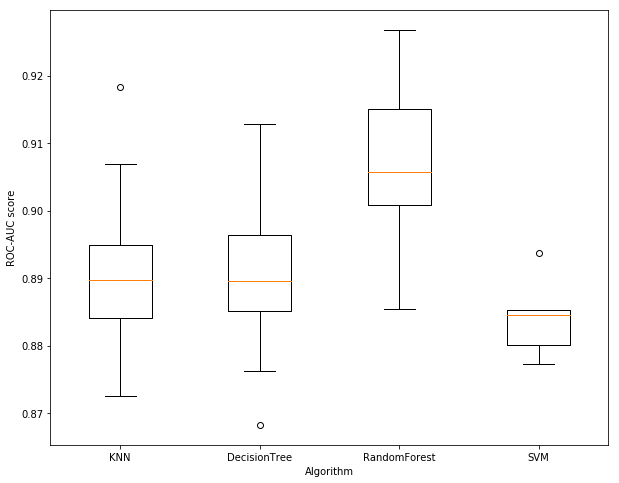

In [80]:
plt.figure(figsize=(10, 8))
data = [cross_val_score_knn, cross_val_score_dt, cross_val_score_rf, cross_val_score_svc]
plt.boxplot(data, labels = ['KNN', 'DecisionTree', 'RandomForest', 'SVM'])
plt.xlabel('Аlgorithm')
plt.ylabel('ROC-AUC score');

Для данной выборки SVM алгоритм показал худший результат, возможно это связано с тем, что параметры подбирались по сетке с большим шагом. Алгоритм работал очень долго, поэтому я не запускала перебор параметров с меньшим шагом. 

## Мультиклассовая классификация

Решим задачу мультиклассовой классификации с линейным классификатором (`LinearSVC`). Ниже представлены сгенерированые выбороки для данной задачи. 

Рассмотрим два подхода к мультиклассовой классификации: [OneVsOneClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) и [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html).

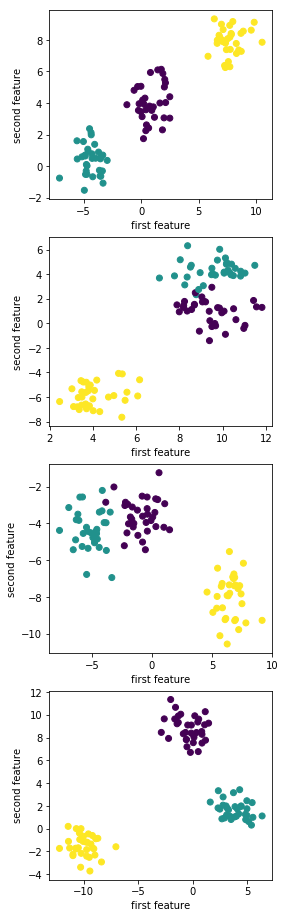

In [278]:
f, axarr = plt.subplots(4, 1, figsize=(4, 16))
for i, ax in enumerate(axarr):
    X, y = make_blobs(n_samples=100, n_features=2, centers=3, random_state=3+i**5)
    ax.scatter(X[:, 0], X[:, 1], c=y)
    ax.set_xlabel('first feature')
    ax.set_ylabel('second feature')

In [279]:
X, y = {}, {}
for i in np.arange(4):
    X[i], y[i] = make_blobs(n_samples=100, n_features=2, centers=3, random_state=3+i**5)

На графике изображены точки выборки, а также разделяющие прямые. В строке представлены изображения для классификаторов OneVsRestClassifier и OneVsOneClassifier на одной выборке.

Код написан на основе кода со страницы http://scikit-learn.org/stable/auto_examples/plot_multilabel.html

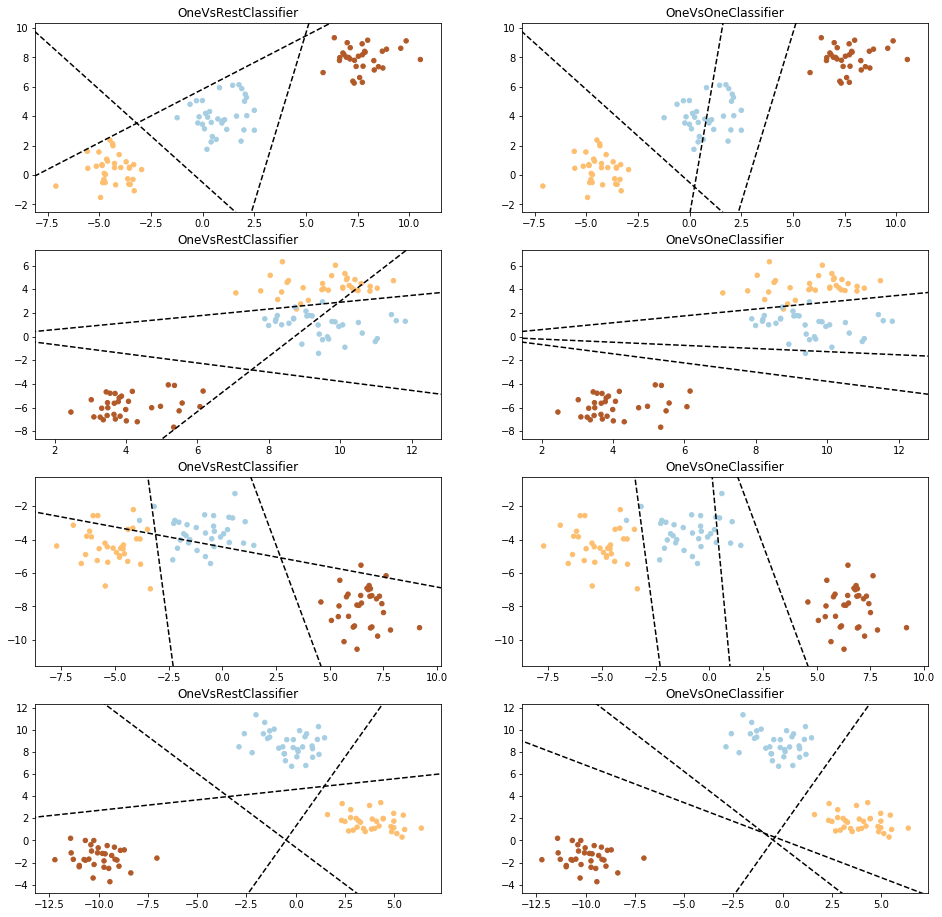

In [285]:
def plot_hyperplane(clf, min_x, max_x, linestyle):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    ax.plot(xx, yy, linestyle)
    
fig, axarr = plt.subplots(len(X.keys()), 2, figsize=(16, 16))
for data_set, num_row in zip(X.keys(), np.arange(0, len(X.keys()))):
        for сlassifier, ax in zip([0, 1], axarr[num_row]):
            
            # fit the model, don't regularize for illustration purposes
            if сlassifier == 0:
                clf = OneVsRestClassifier(LinearSVC(random_state=0))
            else:
                clf = OneVsOneClassifier(LinearSVC(random_state=0))
            clf.fit(X[data_set], y[data_set])

            ax.scatter(X[data_set][:, 0], X[data_set][:, 1], c=y[data_set], s=20, cmap=plt.cm.Paired)
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()


            min_x = np.min(X[data_set][:, 0])
            max_x = np.max(X[data_set][:, 0])
            min_y = np.min(X[data_set][:, 1])
            max_y = np.max(X[data_set][:, 1])
            
            plot_hyperplane(clf.estimators_[0], min_x, max_x, 'k--')
            plot_hyperplane(clf.estimators_[1], min_x, max_x, 'k--')
            plot_hyperplane(clf.estimators_[2], min_x, max_x, 'k--')
            
            ax.set_xlim(min_x - 1, max_x + 1)
            ax.set_ylim(min_y - 1, max_y + 1)
            
            if сlassifier == 0:
                ax.set_title('OneVsRestClassifier')
            else:
                ax.set_title('OneVsOneClassifier')     

С предложенными выборками, как мне кажется, лучше справился метод OneVsOneClassifier. 

Метод OneVsOneClassifier работает дольше при большом числе выборок (число классификаторов квадратично зависит от числа классов), но можно распараллеливать процесс, потому что все работает независимо.

Метод OneVsRestClassifier работает быстрее, потому что количество классификаторов в этом методе растет линейно. Если объект может иметь несколько классов, то используют OneVsRestClassifier, потому что алдгоритм принимает на вход эстиматор бинарной классификации.

## Кластеризация

Рассмотрим задачу кластеризации.

Признаки хорошей кластеризации:
 - объекты внутри кластера должны быть похожи друг на друга,
 - похожие объекты должны попадать в один кластер (этот пункт не следует из предыдущего!),
 - в случае, когда нам известны истинные метки классов, метрика не должна учитывать абсолютные значения меток объектов, полученных из кластеризации.

Вам предлагается сравнить 4 различных метрики:
 - [Homogeneity, Completeness и V-measure](http://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure)
 - [Adjusted Rand index](http://scikit-learn.org/stable/modules/clustering.html#adjusted-rand-index) 
 
Для выполнения задания будем использовать датасет, составленный из рукописных "картинок" цифр.
В `labels` собраны названия цифр, в `digits` - их векторное представление:

In [2]:
digits, labels = sklearn_shuffle(*load_digits(return_X_y=True))

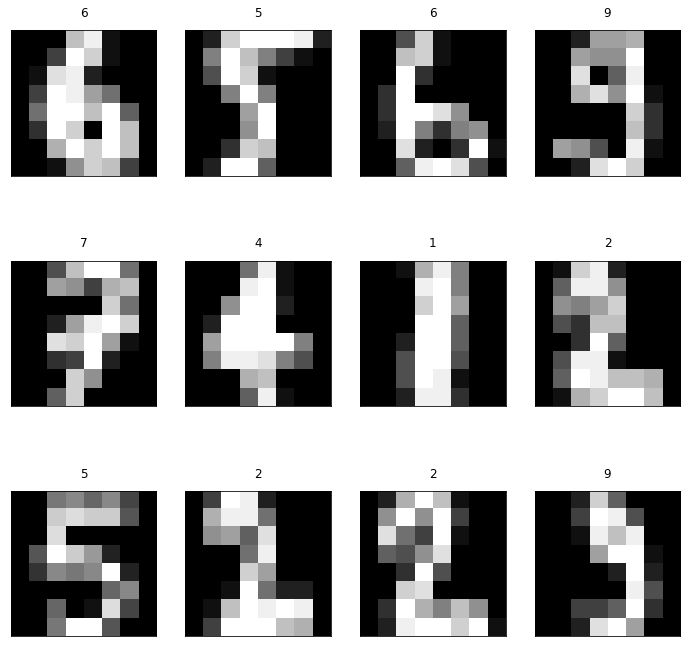

In [3]:
f, axarr = plt.subplots(3, 4, figsize=(12, 12))
plt.gray()
for ax, digit, label in zip(axarr.flatten(), digits, labels):
    ax.matshow(digit.reshape(8, 8))
    ax.tick_params(top='off', labeltop='off', left='off', labelleft='off', bottom='off')
    ax.set_title(label)

Кластеризуем изображения при помощи алгоритма [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html): 
* Построим графики зависимости значений метрик от числа кластеров (от 2 до 20 кластеров).

In [4]:
X = digits

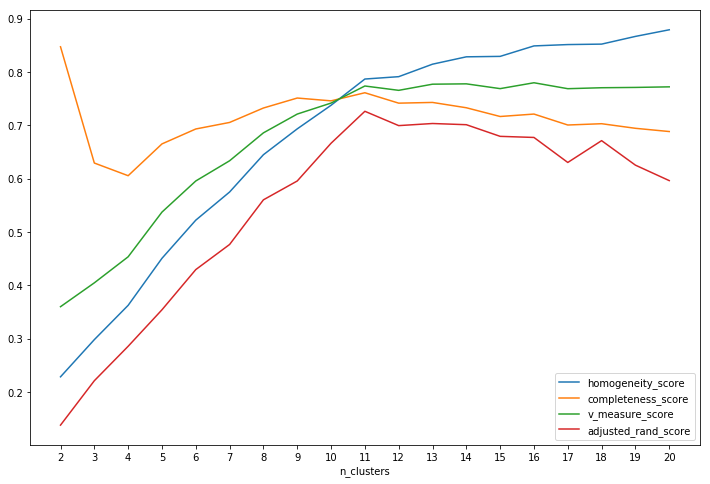

In [450]:
param_grid = np.arange(2, 21)
plt.figure(figsize=(12, 8))
dict_metrics = {}
dict_metrics['homogeneity_score'] = []
dict_metrics['completeness_score'] = []
dict_metrics['v_measure_score'] = []
dict_metrics['adjusted_rand_score'] = []

for n_clusters_value in param_grid:
    kmeans = KMeans(n_clusters = n_clusters_value, random_state=0).fit(X)
    dict_metrics['homogeneity_score'].append(metrics.homogeneity_score(labels, kmeans.labels_))
    dict_metrics['completeness_score'].append(metrics.completeness_score(labels, kmeans.labels_))
    dict_metrics['v_measure_score'].append(metrics.v_measure_score(labels, kmeans.labels_))
    dict_metrics['adjusted_rand_score'].append(metrics.adjusted_rand_score(labels, kmeans.labels_))

for metric in dict_metrics.keys():
    plt.plot(param_grid, dict_metrics[metric], label = metric)    

plt.xticks(param_grid)
plt.xlabel('n_clusters')
plt.legend();

Лучшая класстеризация получилась при значении n_clusters = 11 (согласно метрикам v_measure_score и adjusted_rand_score).

* Визуализируем изображения, соответствующие центроидам лучшей кластеризации:

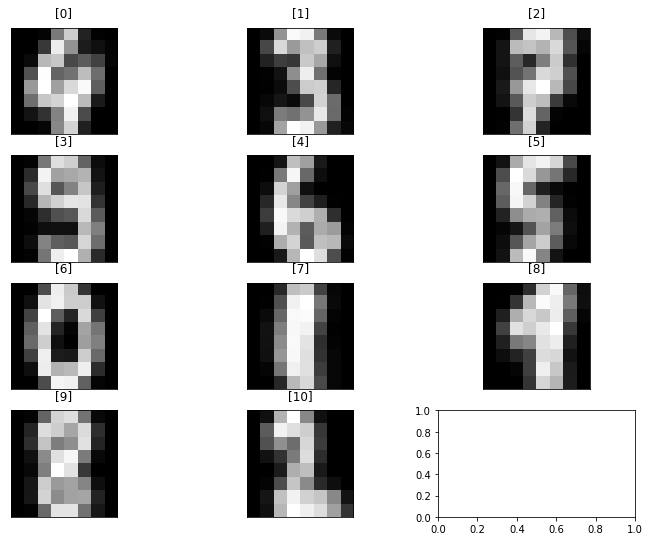

In [386]:
kmeans = KMeans(n_clusters = 11, random_state=0).fit(X)
f, axarr = plt.subplots(4, 3, figsize=(12, 9))
plt.gray()
for ax, cluster in zip(axarr.flatten(), kmeans.cluster_centers_):
    ax.matshow(cluster.reshape(8, 8))
    ax.tick_params(top='off', labeltop='off', left='off', labelleft='off', bottom='off')   
    ax.set_title(str(kmeans.predict([cluster])))

Изображения, соответствующие центроидам лучшей кластеризации, представляют из себя красивые ровные цифры, которые легко опознать. Эти изображения намного правильнее тех, что выходят рандомно из базы данных. Представлены все цифры от 0 до 9, а цифра 1 представлена в двух вариантах написания, что логично. 


* Визуализируем несколько изображений, которые были отнесены к неправильному кластеру в случае лучшей кластеризации:

In [410]:
index_of_cluster_label = {0 : 4, 1 : 3, 2 : 7, 3 : 9, 4 : 6, 5 : 5, 6 : 0, 7 : 1, 8 : 1, 9 : 8, 10 : 2}

for digit, label, index_of_cluster in zip(digits[:30], labels[:30], kmeans.labels_[:30]):
    print('label:', label,  ' predict_label:', index_of_cluster_label[index_of_cluster])


label: 0  predict_label: 0
label: 0  predict_label: 0
label: 4  predict_label: 4
label: 8  predict_label: 1
label: 9  predict_label: 9
label: 3  predict_label: 3
label: 9  predict_label: 9
label: 6  predict_label: 6
label: 8  predict_label: 8
label: 4  predict_label: 4
label: 7  predict_label: 7
label: 0  predict_label: 0
label: 9  predict_label: 9
label: 1  predict_label: 1
label: 9  predict_label: 9
label: 4  predict_label: 4
label: 3  predict_label: 3
label: 7  predict_label: 1
label: 3  predict_label: 3
label: 7  predict_label: 7
label: 4  predict_label: 4
label: 5  predict_label: 5
label: 5  predict_label: 5
label: 5  predict_label: 5
label: 2  predict_label: 2
label: 5  predict_label: 5
label: 9  predict_label: 7
label: 7  predict_label: 7
label: 2  predict_label: 2
label: 8  predict_label: 8


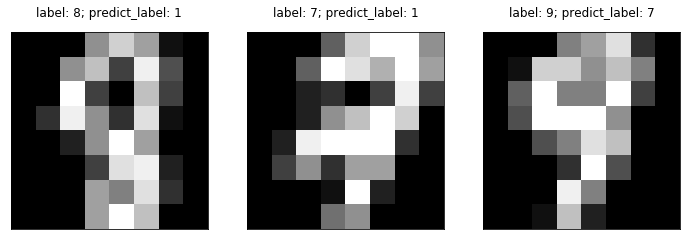

In [409]:
f, axarr = plt.subplots(1, 3, figsize=(12, 4))
plt.gray()
for ax, num in zip(axarr.flatten(), [3, 17, 26]):
    ax.matshow(digits[num].reshape(8, 8))
    ax.set_title('label: ' + str(labels[num])  +  '; predict_label: ' + 
                 str(index_of_cluster_label[kmeans.labels_[num]]))
    ax.tick_params(top='off', labeltop='off', left='off', labelleft='off', bottom='off')


Изображения, которые были отнесены к неправильному кластеру, очень трудно читаются. На них сложно определить написанную цифру. Эти изображения существенно отличаются от изображений, соответствующих центроидам лучшей кластеризации, поэтому алгоритм определил их неправильно. 

Для наглядности попробуем уложить наши данные в двухмерное пространство. Применим [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) и [tSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к имеющися данным и визуалируем полученный результат. 

In [5]:
X_pca = PCA(n_components=2, random_state=1).fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=1).fit_transform(X)

In [28]:
def plot_sample(X, clf):
    plt.figure(figsize=(6, 6))
    plt.scatter(*X.T, s=3)
    X_min, X_max = np.min(X), np.max(X)
    plt.xlim(X_min - 0.2, X_max + 0.2)
    plt.ylim(X_min - 0.2, X_max + 0.2)
    plt.title(clf)

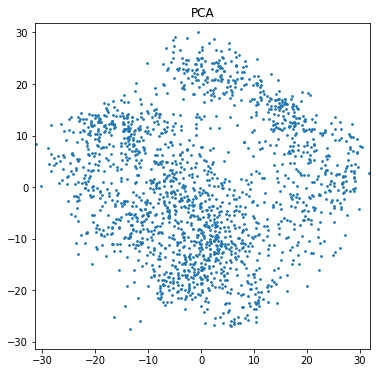

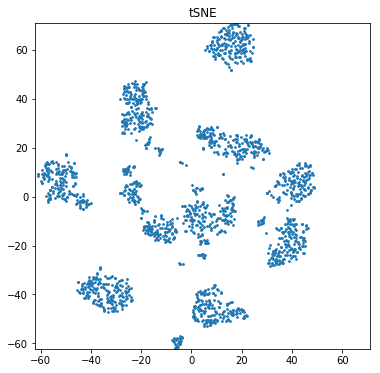

In [29]:
plot_sample(X_pca, 'PCA')
plot_sample(X_tsne, 'tSNE')

В результате работы алгоритма tSNE в двумерном пространстве получено большое число обособленных кластеров. Алгоритм PCA в двумерном пространстве выдал очень слабокластеризованный массив данных. Кажется, что в данной задаче для уменьшения расмерности нельзя использовать PCA, потому что в двумерном пространстве сложно представить, как можно будет  будет выделить кластеры для 10 цифр. 

Если взять код со станицы https://github.com/oreillymedia/t-SNE-tutorial, то можно получить еще более наглядное представление о наших данных в двумерном пространстве по tSNE и PCA:

In [23]:
# That's an impressive list of imports.
from sklearn.datasets import load_digits

# We'll use matplotlib for graphics.
import matplotlib.patheffects as PathEffects

# We import seaborn to make nice plots.
import seaborn as sns
# sns.set_style('darkgrid')
# sns.set_palette('muted')
# sns.set_context("notebook", font_scale=1.5,
#                 rc={"lines.linewidth": 2.5})


digits = load_digits() 
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

#### PCA

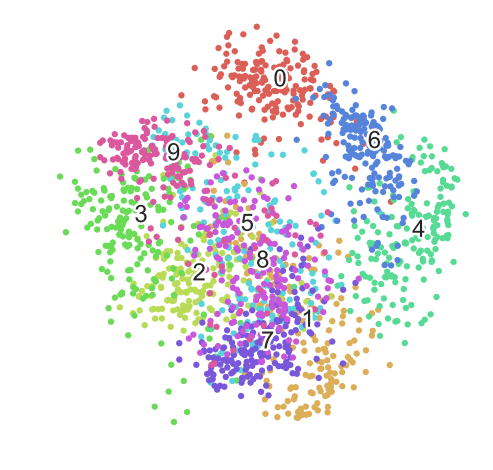

In [35]:
digits_proj = X_pca
scatter(digits_proj, y);

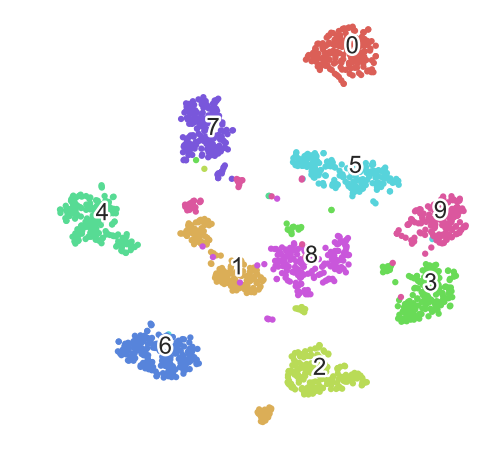

In [33]:
digits_proj = X_tsne
scatter(digits_proj, y);

К данным уменьшенной размерности применим алгоритмы кластеризации [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), [DBSCAN](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html), [AffinityPropagation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html) и [MeanShift](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html). 


Подбор параметров - на ваше усмотрение. Для каких-то методов можно даже не делать перебор или ограничиться небольшой сеткой, главное - аргументировать, почему в этом случае это уместно. Метрику выберите на свою усмотрение, пояснив свой выбор.

Визуалируйте результат кластеризации (с лучшими параметрами) на каждом из способов уменьшения размерности.

Как вы считаете, помогло ли уменьшение размерности в данном датасете? Улучшено ли качество в сравнении с KMeans на полных данных? Сравните алгоритмы кластеризации: в чем преимущества и недостатки каждого из них?

#### KMeans

Будем использовать метрики v_measure_score и adjusted_rand_score, потому что они наиболее точно оценивают качество кластеризации. 

In [183]:
samples = [X_pca, X_tsne]

In [260]:
def score_plot(samples, subplot_names, xlabel, param_grid, сlassifier):
    f, axarr = plt.subplots(1, 2, figsize=(18, 4))
    for X, ax, subplot_name in zip(samples, axarr, subplot_names):
        dict_metrics = {}
        dict_metrics['v_measure_score'] = []
        dict_metrics['adjusted_rand_score'] = []

        for param_value in param_grid:
            if сlassifier == 'kmeans':
                clf = KMeans(n_clusters = param_value, random_state=0).fit(X)  
            if сlassifier == 'DBSCAN':
                clf = DBSCAN(min_samples = 3, eps = param_value).fit(X)
            if сlassifier == 'AffinityPropagation':
                clf = AffinityPropagation(damping = param_value).fit(X)
            if сlassifier == 'MeanShift':
                clf = MeanShift(bandwidth = param_value).fit(X) 
            dict_metrics['v_measure_score'].append(metrics.v_measure_score(labels, clf.labels_))
            dict_metrics['adjusted_rand_score'].append(metrics.adjusted_rand_score(labels, clf.labels_))

        for metric in dict_metrics.keys():
            ax.plot(param_grid, dict_metrics[metric], label = metric)    

        ax.set_xticks(param_grid)
        ax.set_xlabel(xlabel)
        ax.set_title(subplot_name)
        ax.legend();

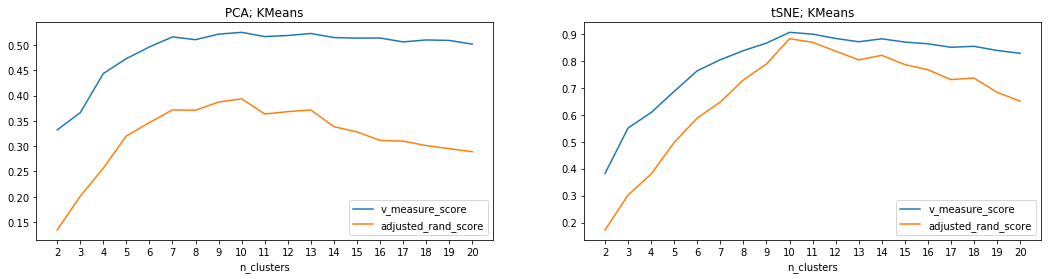

In [217]:
xlabel = 'n_clusters'
subplot_names = ['PCA; KMeans', 'tSNE; KMeans']
param_grid = np.arange(2, 21)
score_plot(samples, subplot_names, xlabel, param_grid, сlassifier = 'kmeans')

Лучший кластеризатор KMeans по PCA имеет число кластеров 10, а по tSNE от 10 до 12 (для 10 незначительно лучше).

In [240]:
def show_plots(samples, clfs, subplot_names):
    f, axarr = plt.subplots(1, 2, figsize=(16, 8))
    for sample, ax, subplot_name, clf in zip(samples, axarr, subplot_names, clfs):
        y = clf.fit_predict(sample)
        сlassifier = clf.fit(sample)
        ax.scatter(*sample.T, c=y, s=5, cmap = plt.matplotlib.cm.jet)
        X_min, X_max = np.min(sample), np.max(sample)
        ax.set_title(subplot_name)
        ax.set_xlim(X_min - 0.2, X_max + 0.2)
        ax.set_ylim(X_min - 0.2, X_max + 0.2)
        print(subplot_name, 'v_measure_score', metrics.v_measure_score(labels, сlassifier.labels_))
        print(subplot_name, 'adjusted_rand_score', metrics.adjusted_rand_score(labels, clf.labels_));

PCA; KMeans v_measure_score 0.525205699239
PCA; KMeans adjusted_rand_score 0.393744630785
tSNE; KMeans v_measure_score 0.906586576504
tSNE; KMeans adjusted_rand_score 0.882900807836


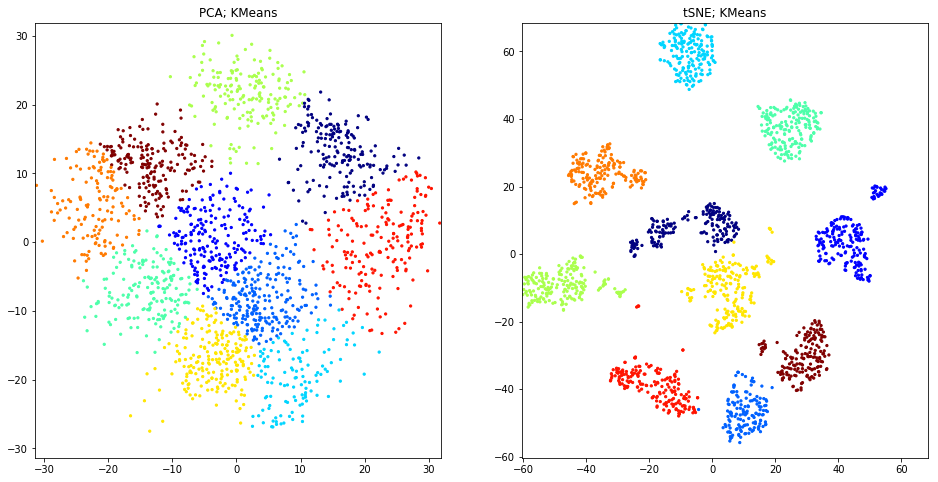

In [241]:
clfs = [KMeans(n_clusters = 10, random_state=0), KMeans(n_clusters = 10, random_state=0)]
subplot_names = ['PCA; KMeans', 'tSNE; KMeans']
show_plots(samples, clfs, subplot_names)

Уменьшение размерности данных алгоритмом tSNE существенно увеличило качество алгоритма KMeans по сравнению с KMeans на полных данных. Уменьшение размерности методом PCA очень сильно ухудшило качество алгаритма KMeans, потому что, как я и предполагала, невозможно нормально выделить такие размазанные и перекрывающиеся кластеры, которые олучились в двумерном пространстве при применении алгоритма PCA к исходным данным. 

#### DBSCAN

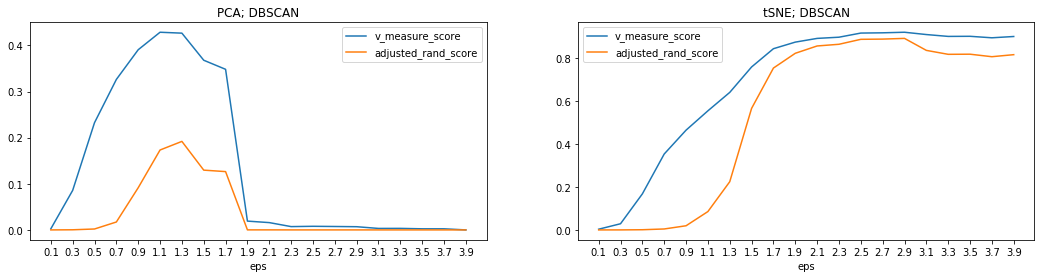

In [230]:
xlabel = 'eps'
subplot_names = ['PCA; DBSCAN', 'tSNE; DBSCAN']
param_grid = np.arange(0.1, 4, 0.2)
score_plot(samples, subplot_names, xlabel, param_grid, сlassifier = 'DBSCAN')

Лучший кластеризатор DBSCAN по PCA имеет eps = 1.3, а по tSNE 2.9.
Значение min_samples возьмем равным 3, потому что в выборке tSNE низкий уровень шума и очень неоднородный набор данных.

PCA; DBSCAN v_measure_score 0.426527950105
PCA; DBSCAN adjusted_rand_score 0.191865948208
tSNE; DBSCAN v_measure_score 0.920025529273
tSNE; DBSCAN adjusted_rand_score 0.891425703307


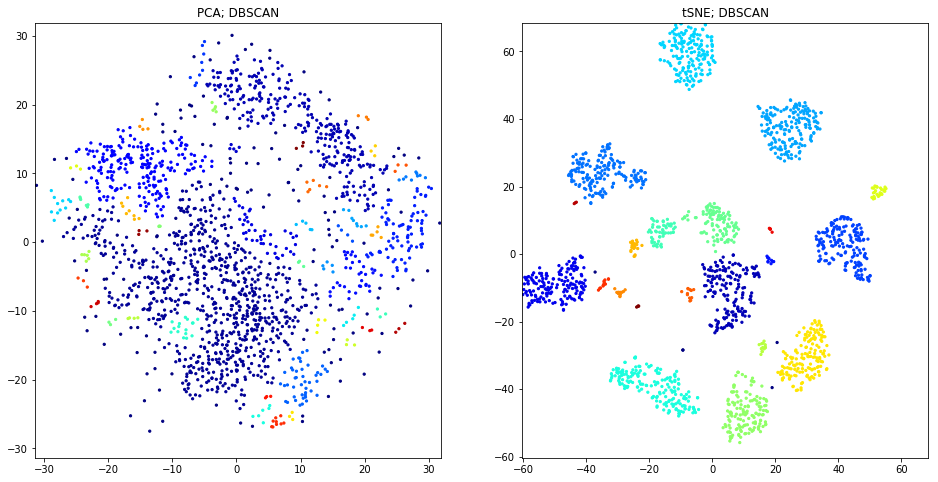

In [243]:
clfs = [DBSCAN(min_samples = 3, eps = 1.3), DBSCAN(min_samples = 3, eps = 2.9)]
subplot_names = ['PCA; DBSCAN', 'tSNE; DBSCAN']
show_plots(samples, clfs, subplot_names)

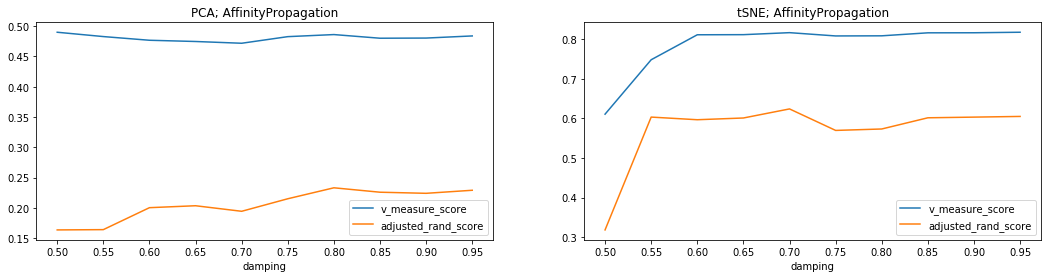

In [251]:
xlabel = 'damping'
subplot_names = ['PCA; AffinityPropagation', 'tSNE; AffinityPropagation']
param_grid = np.arange(0.5, 1, 0.05)
score_plot(samples, subplot_names, xlabel, param_grid, сlassifier = 'AffinityPropagation')

PCA; AffinityPropagation v_measure_score 0.486096428167
PCA; AffinityPropagation adjusted_rand_score 0.233223121084
tSNE; AffinityPropagation v_measure_score 0.816117688926
tSNE; AffinityPropagation adjusted_rand_score 0.623714919427


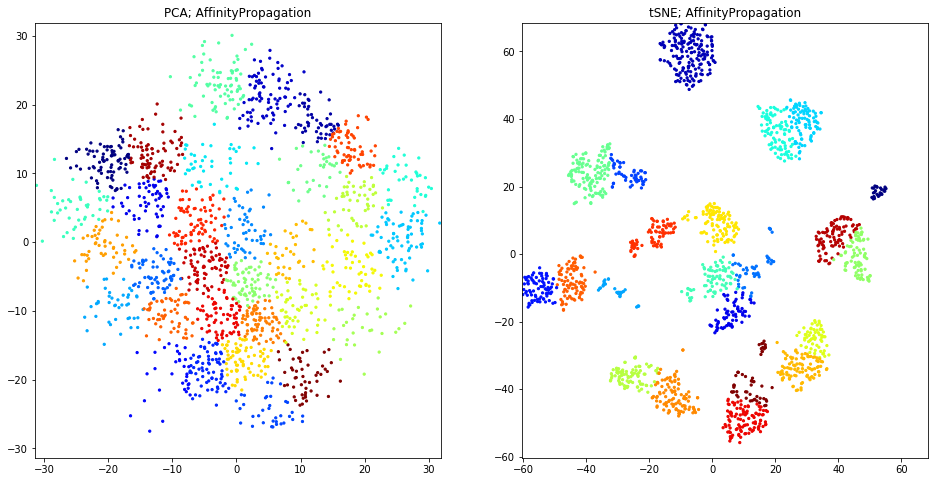

In [252]:
clfs = [AffinityPropagation(damping = 0.8), AffinityPropagation(damping = 0.7)]
subplot_names = ['PCA; AffinityPropagation', 'tSNE; AffinityPropagation']
show_plots(samples, clfs, subplot_names)

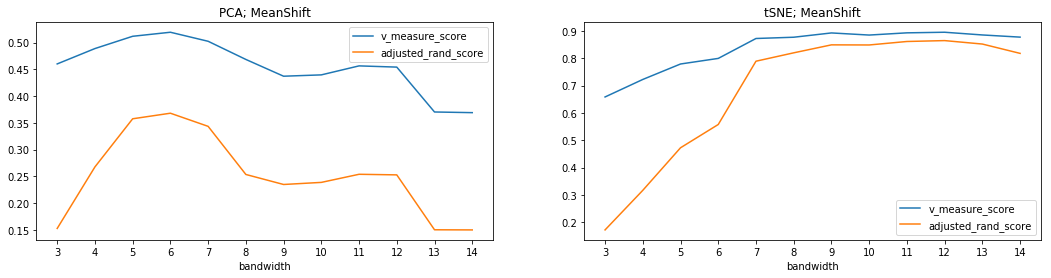

In [264]:
xlabel = 'bandwidth'
subplot_names = ['PCA; MeanShift', 'tSNE; MeanShift']
param_grid = np.arange(3, 15, 1)
score_plot(samples, subplot_names, xlabel, param_grid, сlassifier = 'MeanShift')

PCA; MeanShift v_measure_score 0.519316007901
PCA; MeanShift adjusted_rand_score 0.367945338278
tSNE; MeanShift v_measure_score 0.89490184174
tSNE; MeanShift adjusted_rand_score 0.864356366767


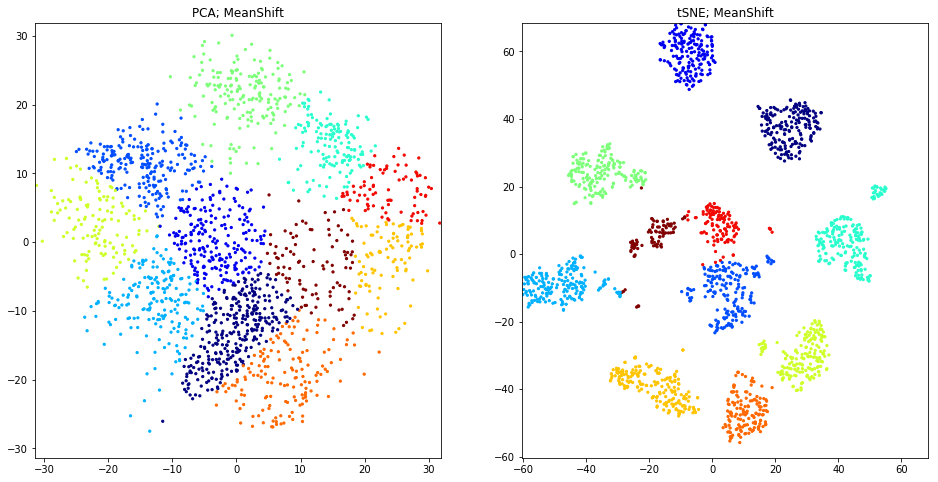

In [265]:
clfs = [MeanShift(bandwidth = 6), MeanShift(bandwidth = 12)]
subplot_names = ['PCA; MeanShift', 'tSNE; MeanShift']
show_plots(samples, clfs, subplot_names)

На данном наборе данных c tSNE по метрикам v_measure_score и adjusted_rand_score лучше всего сработал алгоритм DBSCAN. На втором месте алгоритм KMeans, на третьем MeanShift, хуже всего справился алгоритм AffinityPropagation. 

DBSCAN:
* не требует задания числа кластеров;
* ищет кластеры любой формы;
* устойчив к шуму;
* имеет только 2 параметра;
* недетерминирован;
* плохо работает в случае кластеров разных плотностей;
* может плохо работать в случае кластеров с перемычками.

KMeans:
* легко интерпретируется;
* результат сильно зависит от начального расположения центров кластеров;
* необходимо задавать число кластеров;
* результат зависит от нормировки признаков.

MeanShift:
* легко интерпретируется;
* число кластеров подбирается алгоритмом;
* кластеризация зависит от параметров ядра;
* плохо работает с кластерами сложной формы.

AffinityPropagation:
* подвержен вычислительным осцилляциям в случаях, когда есть несколько хороших разбиений на кластеры;
* не требует задания числа кластеров;
* размеры кластеров варьируются в довольно небольших пределах, и если в датасете есть сильно различные по размеру скопления, AP может либо пропустить маленькие, либо посчитать большие за несколько;
* часто  нуждается в постобработке — дополнительной кластеризации лидеров групп.

## Исследовательская задача

Дан массив текстов, нужно выделить в этих текстах тематики. Данные представлены в виде матрицы [TF-IDF](https://ru.wikipedia.org/wiki/TF-IDF).

Загрузим тексты:

In [3]:
with open('texts.pickle', 'rb') as f:
    texts = pickle.load(f)

Примеры записей:

In [4]:
for text in sample(texts, 2):
    print(text)
    print(80 * '=')


Of course, if you're a criminal, or hang around with criminals, or
flash large wads of cash in the wilder parts of town, or utter verbal
bigotry in the right public places, your chances of being shot are much
higher.

Avoiding these behaviors, on the other hand, decreases your chances of
being shot.

Something like 60% of all murders are criminals killing criminals. 
Over 90% of murders are committed by people with a prior *known*
history of violence.

Simplistic moral, suitable for my three year old, and most inane
posters:  "Bad people do bad things - repeatedly."


And Noemi makes me think of "cuddle", not "KotL".


В текстах могут присутствовать подписи авторов, смайлики, сленговые слова. Часть текстов могут быть пустыми или содержать мало слов.

Ниже построена матрица TF-IFD для этого корпуса текстов. В данной реализации оставлены только слова длины больше 3 и не рассматриваются стоп-слова из английского языка (например, "and", "the", "by"). Более подробно об инструменте для создания TF-IDF матрицы можно почитать [тут](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

**Важно!** Матрица хранится в sparse виде, работа с ней в dense форме может быть вычислительно сложна.

In [5]:
vectorizer = TfidfVectorizer(token_pattern=u'[a-z][a-z][a-z]+', stop_words='english')
tf_idf = vectorizer.fit_transform(texts)

In [6]:
type(tf_idf), tf_idf.shape

(scipy.sparse.csr.csr_matrix, (2334, 23431))

Можно получить список слов, соответствующих колонкам матрицы, следующей командой:

In [7]:
words = vectorizer.get_feature_names()
print(sample(words, 10))

['howie', 'libya', 'passive', 'governemtn', 'faceshield', 'therapy', 'dichotomy', 'jerks', 'laughter', 'recound']


In [31]:
svd = TruncatedSVD(n_components=10)
US = svd.fit_transform(tf_idf)
S = svd.singular_values_
Vt = svd.components_

Попробуем представить сообщения векторами небольшой размерности. Изначально каждое сообщение у нас представлена огромным количеством признаков: tf-idf индексами всех слов. SVD позволяет значительную часть информации собрать в нескольких новых признаках; тем самым, сообщения будут представлены достаточно короткими векторами.

Зададим число компонент равным 10 и визуализуем сообщения в пространстве первых трёх новых признаков. 

Какие геометрические особенности датасета становятся видны? Стоят ли за этим какие-то содержательные закономерности?